### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import webbrowser

In [ ]:
# Verificar a estruura de um arquivo
abril2018_df = pd.read_csv('dataset/abril2018.csv')
display(abril2018_df)

print(abril2018_df.columns)

C:\Users\tamyc\AppData\Local\Temp\ipykernel_23760\2641639194.py:2: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  abril2018_df = pd.read_csv('dataset/abril2018.csv')


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.38
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,f,NaN,NaN,t,f,strict,f,f,1,2.17
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,f,NaN,NaN,f,f,strict,f,f,1,0.92
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,f,NaN,NaN,f,f,strict,t,t,3,2.17
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,f,NaN,NaN,t,f,strict,f,f,1,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39738,24393697,https://www.airbnb.com/rooms/24393697,20180414160018,2018-04-15,1 bedroom in Botafogo,"1 bedroom apartment, with a double mattress, g...",NaN,"1 bedroom apartment, with a double mattress, g...",none,NaN,...,f,NaN,NaN,t,f,flexible,f,f,2,NaN
39739,24393826,https://www.airbnb.com/rooms/24393826,20180414160018,2018-04-14,Apartamento em Copacabana,Apartamento privado em mobiliado em Copacabana...,NaN,Apartamento privado em mobiliado em Copacabana...,none,NaN,...,f,NaN,NaN,f,f,flexible,f,f,2,NaN
39740,24394510,https://www.airbnb.com/rooms/24394510,20180414160018,2018-04-14,"Apartamento 2 quartos, frente mar COPACABANA","Ampla sala, cozinha, 2 quartos, banheiro, vist...",NaN,"Ampla sala, cozinha, 2 quartos, banheiro, vist...",none,NaN,...,f,NaN,NaN,t,f,flexible,f,f,2,NaN
39741,24395755,https://www.airbnb.com/rooms/24395755,20180414160018,2018-04-15,Apto maayan,"Apartamento super confortável com wifi, TV a cabo",NaN,"Apartamento super confortável com wifi, TV a cabo",none,NaN,...,f,NaN,NaN,t,f,flexible,f,f,1,1.00


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [ ]:
# Verificar a estruura de um arquivo
#abril2018_df = pd.read_csv('dataset/abril2018.csv')
#display(abril2018_df)

# Importa todos os arquivos da pasta dataset
caminho_bases = pathlib.Path('dataset')

# Visualizar o resultado
for arquivo in caminho_bases.iterdir():
    print(arquivo.name)

abril2018.csv
abril2019.csv
abril2020.csv
agosto2018.csv
agosto2019.csv
dezembro2018.csv
dezembro2019.csv
fevereiro2019.csv
fevereiro2020.csv
janeiro2019.csv
janeiro2020.csv
julho2018.csv
julho2019.csv
junho2019.csv
maio2018.csv
maio2019.csv
maio2020.csv
maro2019.csv
maro2020.csv
novembro2019.csv
novrmbro2018.csv
outubro2018.csv
outubro2019.csv
setembro2018.csv
setembro2019.csv


In [2]:
# Mapeamento dos meses abreviados para número
meses = {
    'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4,
    'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8,
    'set': 9, 'out': 10, 'nov': 11, 'dez': 12
}

# Caminho da pasta com os arquivos CSV
caminho_bases = pathlib.Path('dataset')

# Lista para armazenar os DataFrames
lista_df = []

# Itera pelos arquivos da pasta
for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3].lower()
    
    if nome_mes not in meses:
        print(f"Mês não reconhecido em: {arquivo.name}")
        continue

    mes = meses[nome_mes]
    
    try:
        ano = int(arquivo.name[-8:].replace('.csv', ''))
    except ValueError:
        print(f"Ano inválido em: {arquivo.name}")
        continue

    # Lê o arquivo
    df = pd.read_csv(arquivo, low_memory=False)
    
    # Adiciona as colunas de data
    df['ano'] = ano
    df['mes'] = mes
    
    # Adiciona à lista
    lista_df.append(df)

# Concatena todos os DataFrames em um só
base_airbnb = pd.concat(lista_df, ignore_index=True)

In [ ]:
display(base_airbnb)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
902207,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


In [ ]:
print(base_airbnb.mes)
print(base_airbnb.ano)

0         4
1         4
2         4
3         4
4         4
         ..
902205    9
902206    9
902207    9
902208    9
902209    9
Name: mes, Length: 902210, dtype: int64
0         2018
1         2018
2         2018
3         2018
4         2018
          ... 
902205    2019
902206    2019
902207    2019
902208    2019
902209    2019
Name: ano, Length: 902210, dtype: int64


Limpeza

Excluindo os atributos que não contribuiem para a formação do valor da diaria.
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais

In [ ]:
# Cria um arquivo csv com os primeiros 1000 registros separados por ;
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

In [ ]:
base_airbnb

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
902207,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


In [ ]:
# Coluna experiences_offered possui uma quantidade significativa de None
print((base_airbnb['experiences_offered'].value_counts()).value_counts())
# Todos os registros ssão iguais

count
902210    1
Name: count, dtype: int64


In [ ]:
# print(base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count'])
# São colunas iguais
print((base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count']).value_counts())
# Somente 460 registro são falso

True     901750
False       460
Name: count, dtype: int64


In [ ]:
print(base_airbnb['square_feet'].isnull().sum())
# A grande maioria e nulo

888162


### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [ ]:
colunas  = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

# Filtrar as colunas selecionadas da base completa
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902206,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902207,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
902208,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


## Tratar valores faltantes


In [ ]:
print(base_airbnb.shape)

(902210, 34)


In [ ]:
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [ ]:
# As colunas que possuem mais de 300k nulo serão excluidas (host_response_time, host_response_rate, review_scores_rating,
# review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location,
# review_scores_value, security_deposit, cleaning_fee
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() >= 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [ ]:
print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(902210, 34)
host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650

In [ ]:
#Para as demais coluans com dados faltantes, como temos mais de 900k linhas para análise, podemos excluir essas linhas com valores faltantes.
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)

(897709, 23)


## Verificar Tipos de Dados em cada coluna

In [ ]:
print(base_airbnb.dtypes)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
host_is_superhost                                                           f
host_listings_count                                                       1.0
la

In [ ]:
# price e extra_people está como object e deve ser float
# Para transformar esse valor precisa tirar o $ e a virgula
base_airbnb['price'] = base_airbnb['price'].astype(str)
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False) #Foi usado float32 para usar menos espaço de memoria

base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(str)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

print(base_airbnb.dtypes)
print(base_airbnb.iloc[0])


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
host_is_superhost                                                           f
host_listings_count                                                       1.0
la

In [ ]:
# Transformando os outros float64 em float32
base_airbnb['host_listings_count'] = base_airbnb['host_listings_count'].astype(np.float32, copy=False)
base_airbnb['latitude'] = base_airbnb['latitude'].astype(np.float32, copy=False)
base_airbnb['longitude'] = base_airbnb['longitude'].astype(np.float32, copy=False)
base_airbnb['bathrooms'] = base_airbnb['bathrooms'].astype(np.float32, copy=False)
base_airbnb['bedrooms'] = base_airbnb['bedrooms'].astype(np.float32, copy=False)
base_airbnb['beds'] = base_airbnb['beds'].astype(np.float32, copy=False)

print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float32
latitude                    float32
longitude                   float32
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float32
bedrooms                    float32
beds                        float32
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


In [ ]:
#Tratando os int6
base_airbnb['accommodates'] = base_airbnb['accommodates'].astype(np.int32, copy=False)
base_airbnb['guests_included'] = base_airbnb['guests_included'].astype(np.int32, copy=False)
base_airbnb['minimum_nights'] = base_airbnb['minimum_nights'].astype(np.int32, copy=False)
base_airbnb['maximum_nights'] = base_airbnb['maximum_nights'].astype(np.int32, copy=False)
base_airbnb['number_of_reviews'] = base_airbnb['number_of_reviews'].astype(np.int32, copy=False)
base_airbnb['ano'] = base_airbnb['ano'].astype(np.int32, copy=False)
base_airbnb['mes'] = base_airbnb['mes'].astype(np.int32, copy=False)

In [ ]:
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float32
latitude                    float32
longitude                   float32
property_type                object
room_type                    object
accommodates                  int32
bathrooms                   float32
bedrooms                    float32
beds                        float32
bed_type                     object
amenities                    object
price                       float32
guests_included               int32
extra_people                float32
minimum_nights                int32
maximum_nights                int32
number_of_reviews             int32
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int32
mes                           int32
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir

- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

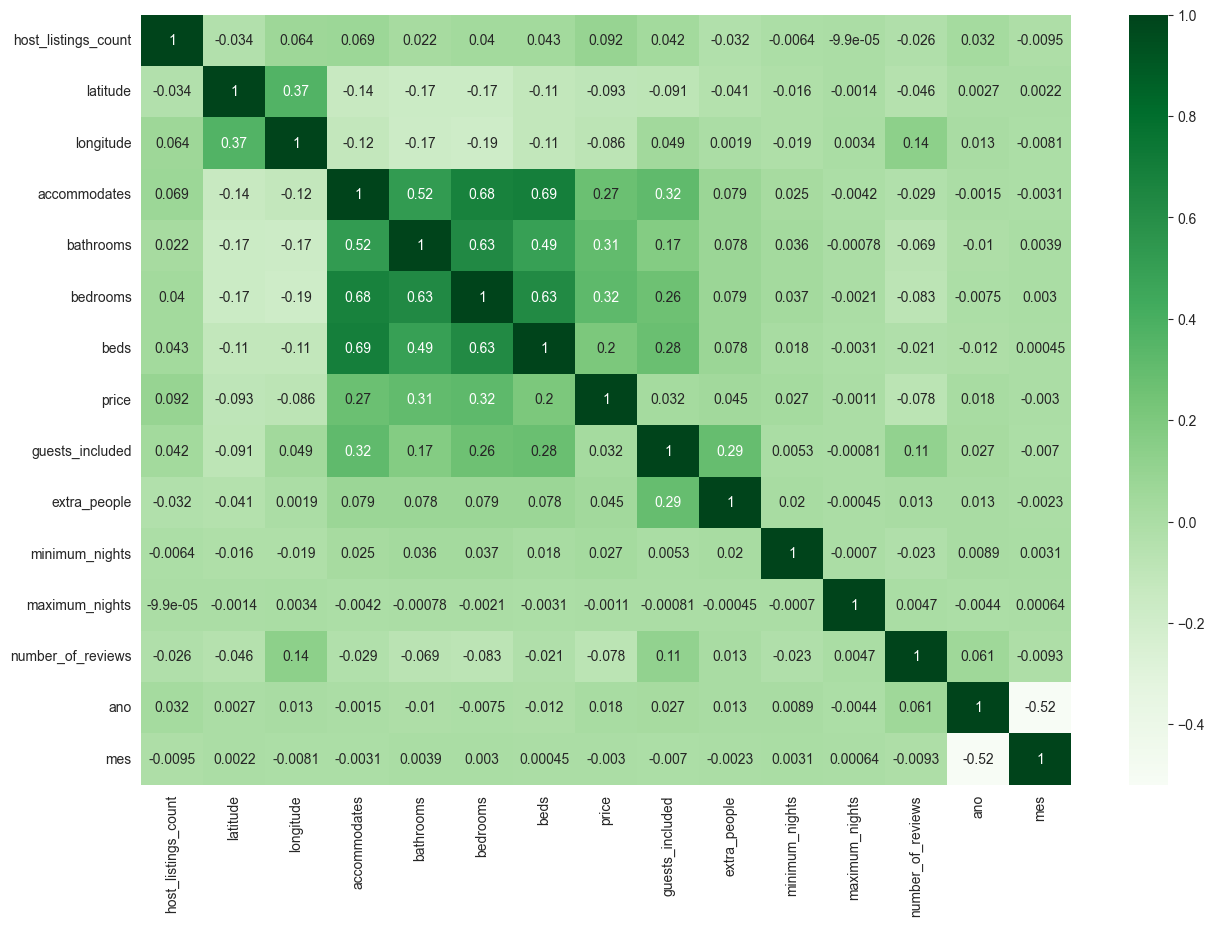

In [ ]:
# Primeiro passo, analisar as correlações entre as colunas
#print(base_airbnb.corr())
#plt.figure(figsize=(15,5))
#sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')
# Selecionar apenas as colunas numéricas
df_numerico = base_airbnb.select_dtypes(include=['number'])

# Gerar heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_numerico.corr(), annot=True, cmap='Greens')
plt.show()

# Analisando as correlações, pode-se avaliar que não existe nenhuma correlaççao direta muito forte, que poderiam ter o mesmo comportamento. Nesse caso, podemos partir para avaliação de cada um dos itens isoladamente

## Definição das funções para análise de outliers
Para definir os limites superior e inferior usaremos como regra, valores abaixo de Q1 - 1.5 x Amplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1

In [ ]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude    #Limite inferior e limite superior

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(10, 3))
    sns.histplot(coluna, kde=True)

def grafico_barra(coluna):
    plt.figure(figsize=(10, 3))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))


## Análise da Coluna Price
(número contínuo)

In [ ]:
base_airbnb['price'].describe()

count    897709.000000
mean        647.922302
std        1705.998169
min           0.000000
25%         151.000000
50%         297.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64

In [ ]:
print((base_airbnb['price'] == 0).sum())

264


In [ ]:
# Excluindo as linhas com valores de alugue igual a 0
base_airbnb = base_airbnb[base_airbnb['price'] != 0]

(np.float64(-524.0), np.float64(1276.0))


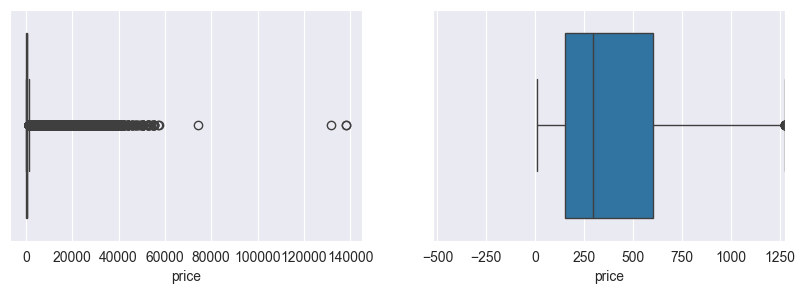

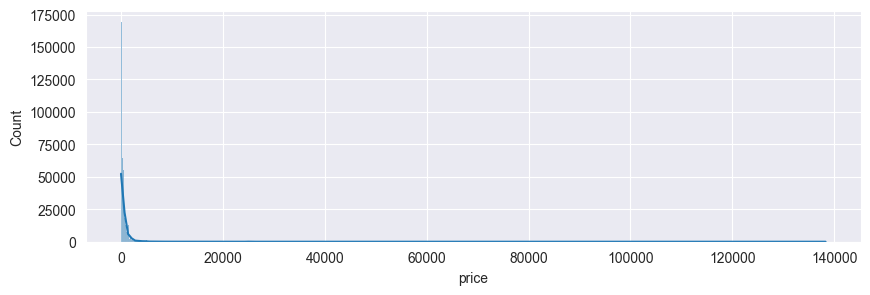

In [ ]:
print(limites(base_airbnb['price']))
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas.'.format(linhas_removidas))

87282 linhas removidas.


In [ ]:
base_airbnb['price'].describe()

count    810427.000000
mean        353.888885
std         284.113098
min           0.000000
25%         149.000000
50%         251.000000
75%         491.000000
max        1276.000000
Name: price, dtype: float64

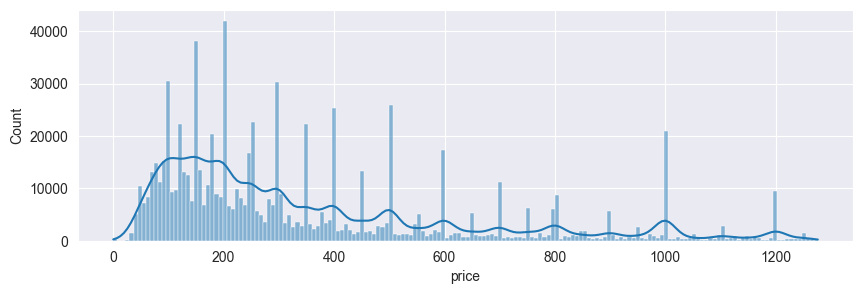

In [ ]:
# PRICE
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imoveis comuns, acretido que os valores acima do limite superior que é de 1.2k os imoveis com aluguel acima desse valor (entende-se que são imoveis de alto padrão) serão excluidos do modelo. Considerando que o aluguel de imoveis de alto padrão levam em consideração outras questões.

## Análise da Coluna Extra People
(número contínuo)

In [ ]:
base_airbnb['extra_people'].describe()

count    751233.000000
mean         21.729952
std          33.461040
min           0.000000
25%           0.000000
50%           0.000000
75%          45.000000
max         125.000000
Name: extra_people, dtype: float64

(np.float64(-75.0), np.float64(125.0))


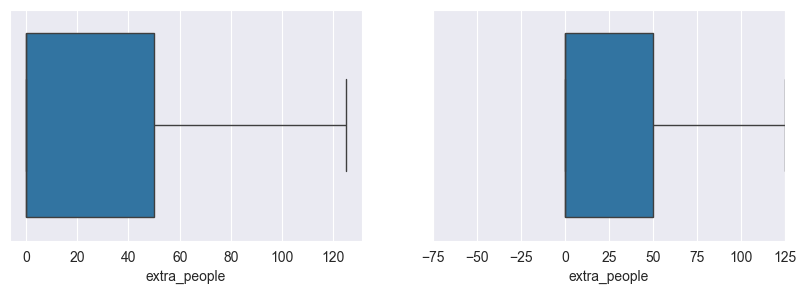

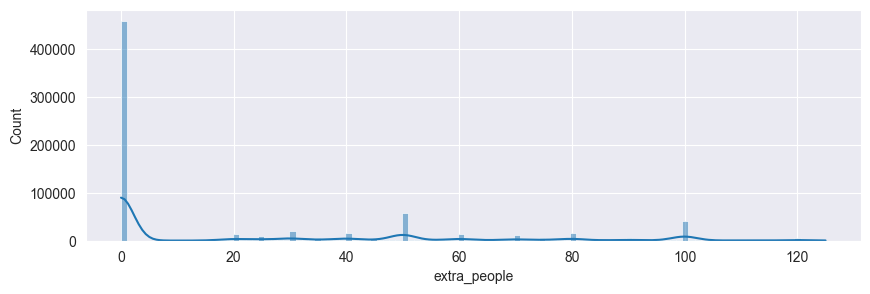

In [ ]:
print(limites(base_airbnb['extra_people']))
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])
# A grande maioria não cobra ou cobra uma taxa menor de 100. Com essa configuração, os que cobram mais de 100 estão sendo configurados como outlier. Inicialmente, irei retirar esses valores.

59194 linhas removidas.


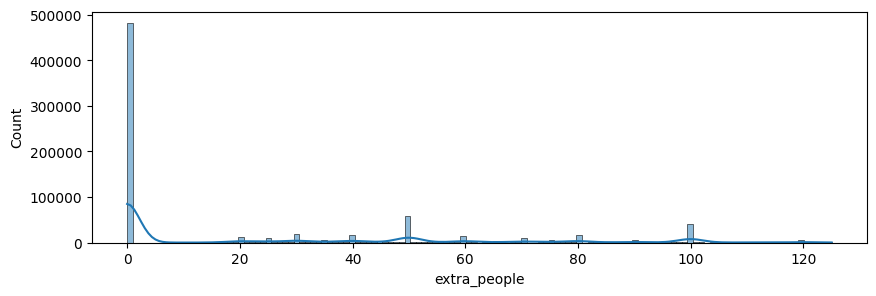

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas.'.format(linhas_removidas))
histograma(base_airbnb['extra_people'])

In [ ]:
base_airbnb['extra_people'].describe()

count    751233.000000
mean         21.729952
std          33.461040
min           0.000000
25%           0.000000
50%           0.000000
75%          45.000000
max         125.000000
Name: extra_people, dtype: float64

## Análise da coluna Host_listings-count
Essa coluna representa quantos anúncios um mesmo anfitrião tem na plataforma do Airbnb

In [ ]:
base_airbnb['host_listings_count'].describe()

count    726277.000000
mean          8.007277
std          33.853107
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1321.000000
Name: host_listings_count, dtype: float64

(np.float64(-2.0), np.float64(6.0))


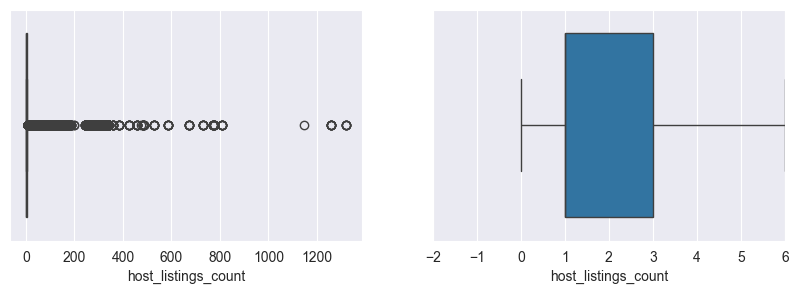

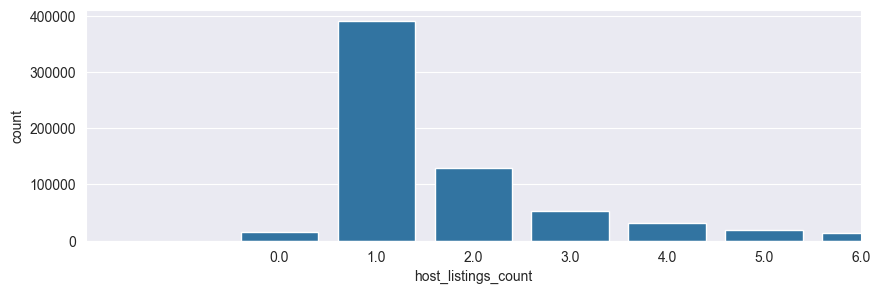

In [ ]:
print(limites(base_airbnb['host_listings_count']))
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

In [ ]:
base_airbnb['host_listings_count'].value_counts()

host_listings_count
1.0      391506
2.0      128922
3.0       53462
4.0       31266
5.0       18732
          ...  
336.0         1
488.0         1
329.0         1
473.0         1
114.0         1
Name: count, Length: 188, dtype: int64

In [ ]:
# Podemos exluir os outliers porque parao objetivo do projeto um host com mais de seis imóveis no airbnb não é o publico do sistema. Suponho que esses host sejam imobiliarias ou profissionais que gerenciam imoveis no airbnb.
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas.'.format(linhas_removidas))

97723 linhas removidas.


## Análise da coluna accommodates

In [ ]:
base_airbnb['accommodates'].describe()

count    751233.000000
mean          3.866579
std           2.172659
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max          16.000000
Name: accommodates, dtype: float64

(np.float64(-1.0), np.float64(7.0))


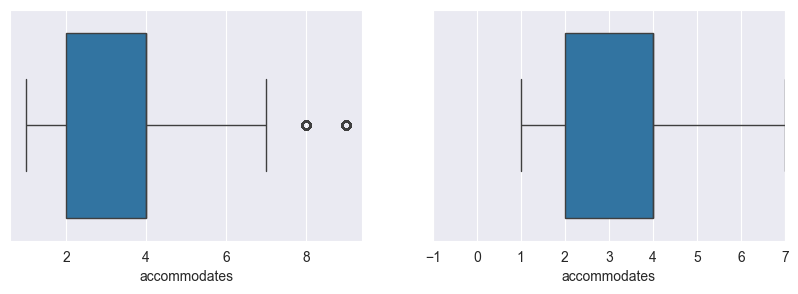

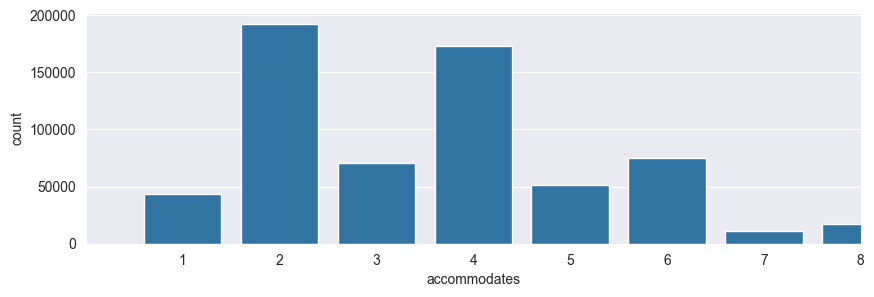

In [ ]:
print(limites(base_airbnb['accommodates']))
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas.'.format(linhas_removidas))

13146 linhas removidas.


## Análise da coluna bathrooms

In [ ]:
base_airbnb['bathrooms'].describe()

count    732681.000000
mean          1.484802
std           0.973108
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         200.000000
Name: bathrooms, dtype: float64

(np.float64(-0.5), np.float64(3.5))


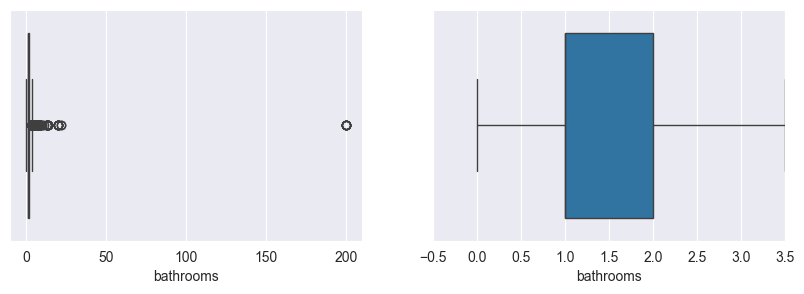

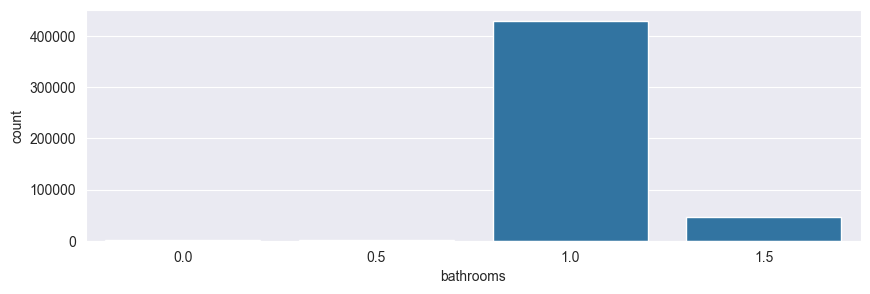

In [ ]:
print(limites(base_airbnb['bathrooms']))
diagrama_caixa(base_airbnb['bathrooms'])
grafico_barra(base_airbnb['bathrooms'])

In [ ]:
base_airbnb['bathrooms'].value_counts()

bathrooms
1.0      429945
2.0      177923
1.5       46206
3.0       38902
2.5       23116
4.0        5354
3.5        5188
0.0        1984
0.5        1078
4.5        1003
5.0         878
8.0         297
6.0         289
7.0         177
5.5         168
6.5          80
7.5          39
9.0          14
13.0          9
20.0          8
200.0         8
8.5           5
13.5          5
10.0          2
22.0          2
11.0          1
Name: count, dtype: int64

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas.'.format(linhas_removidas))

6894 linhas removidas.


## Análise da coluna bedrooms

In [ ]:
base_airbnb['bedrooms'].describe()

count    724342.000000
mean          1.420239
std           0.799632
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          13.000000
Name: bedrooms, dtype: float64

(np.float64(-0.5), np.float64(3.5))


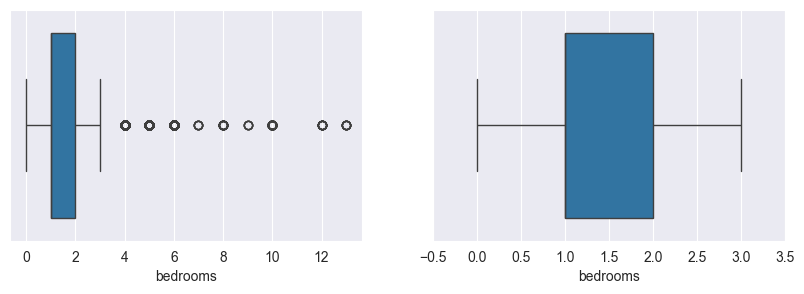

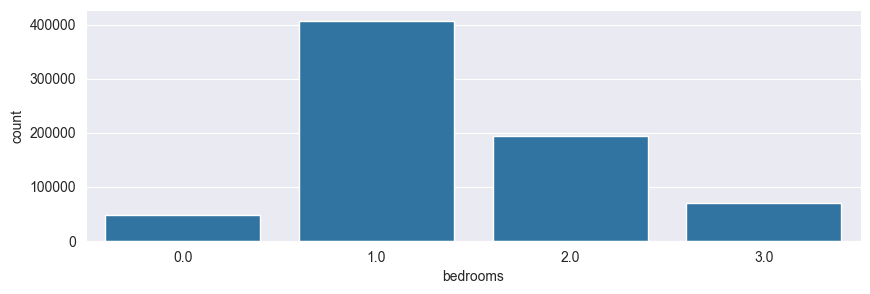

In [ ]:
print(limites(base_airbnb['bedrooms']))
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas.'.format(linhas_removidas))

5482 linhas removidas.


## Análise da coluna beds

In [ ]:
base_airbnb['beds'].describe()

count    724342.000000
mean          2.228092
std           1.390774
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          50.000000
Name: beds, dtype: float64

In [ ]:
base_airbnb['beds'].value_counts()

beds
1.0     266925
2.0     215639
3.0     123257
4.0      64395
5.0      26575
6.0      15434
0.0       4122
7.0       3619
8.0       3060
9.0        736
10.0       371
11.0        94
14.0        45
12.0        26
16.0        25
13.0         8
15.0         3
23.0         3
17.0         2
50.0         1
25.0         1
18.0         1
Name: count, dtype: int64

(np.float64(-2.0), np.float64(6.0))


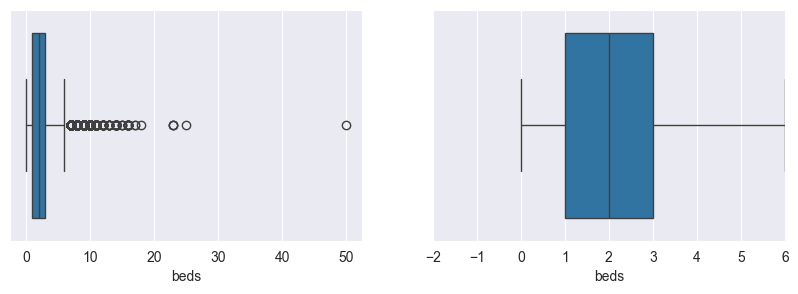

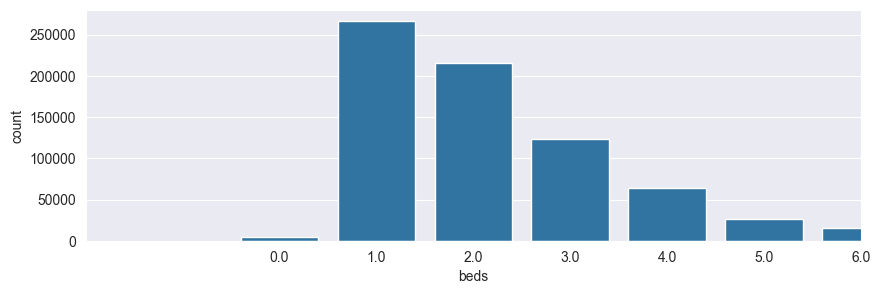

In [ ]:
print(limites(base_airbnb['beds']))
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas.'.format(linhas_removidas))

5622 linhas removidas.


## Análise da coluna guests_included

In [ ]:
base_airbnb['guests_included'].describe()

count    710683.000000
mean          1.524405
std           1.145099
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          16.000000
Name: guests_included, dtype: float64

In [ ]:
base_airbnb['guests_included'].value_counts()

guests_included
1     530255
2      95874
4      42489
3      19441
6      11056
5       8681
7       1445
8        961
9        173
16        89
10        82
12        57
15        37
11        33
14        10
Name: count, dtype: int64

(np.float64(-0.5), np.float64(3.5))


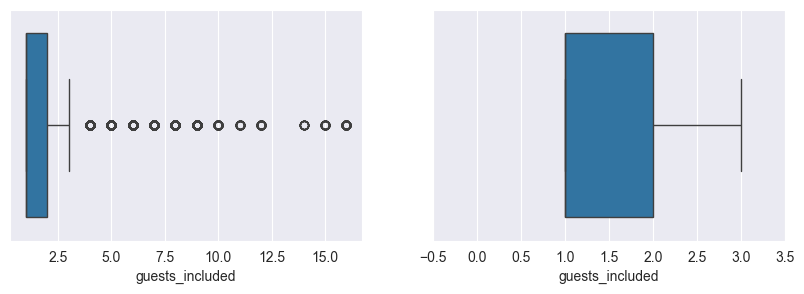

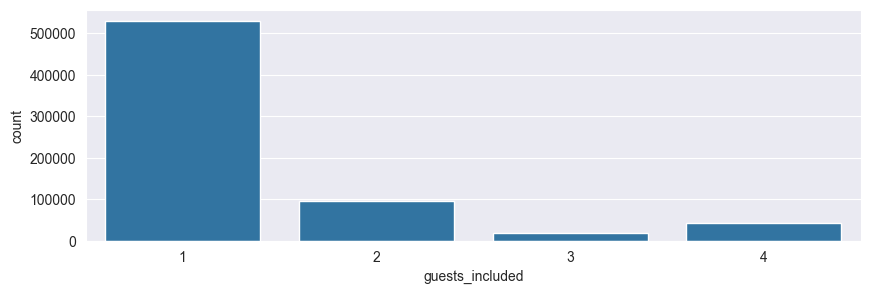

In [ ]:
print(limites(base_airbnb['guests_included']))
diagrama_caixa(base_airbnb['guests_included'])
grafico_barra(base_airbnb['guests_included'])

In [ ]:
# Esses números nao estão apresentando confiabilidade pois não faz sentido que mais da metade da base so permita uma pessoa. Por isso, essa coluna será removida da análise.
base_airbnb = base_airbnb.drop('guests_included', axis=1)

## Análise da coluna minimum_nights

In [ ]:
base_airbnb['minimum_nights'].describe()

count    710683.000000
mean          4.114410
std          17.778371
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1224.000000
Name: minimum_nights, dtype: float64

In [ ]:
base_airbnb['minimum_nights'].value_counts()

minimum_nights
1      207417
2      182795
3      139238
5       52991
4       47039
        ...  
213         1
96          1
36          1
280         1
222         1
Name: count, Length: 90, dtype: int64

(np.float64(-3.5), np.float64(8.5))


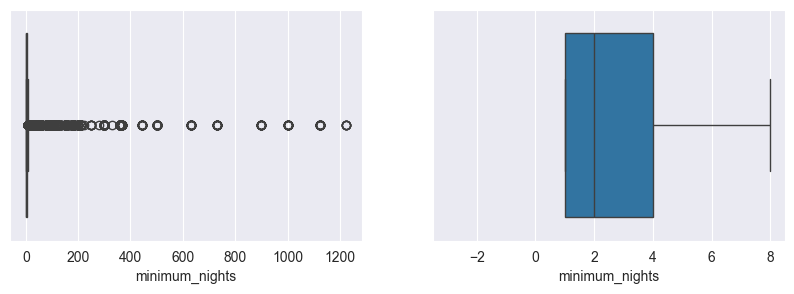

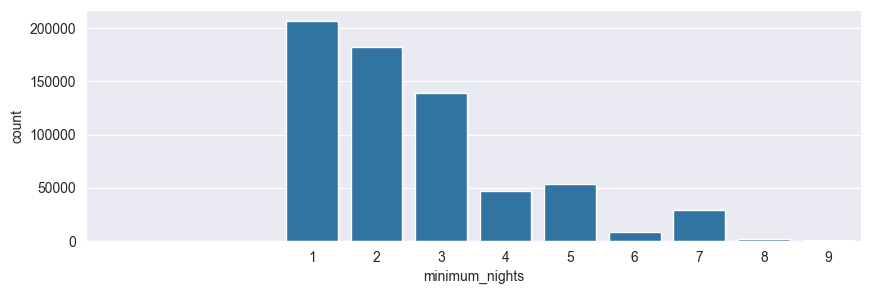

In [ ]:
print(limites(base_airbnb['minimum_nights']))
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [ ]:
# A coluna de minimum_nights apresenta uma correlação muito baixa com a coluna price, esses valores são de 0,0.. e 0,00... Essa coluna poderá ser retirada da análise.
# Por enquanto, irei apenas retirar os outliers.
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas.'.format(linhas_removidas))

40383 linhas removidas.


## Análise da coluna maximum_nights

In [ ]:
base_airbnb['maximum_nights'].describe()

count    7.106830e+05
mean     5.222017e+04
std      8.228544e+06
min      1.000000e+00
25%      3.000000e+01
50%      1.125000e+03
75%      1.125000e+03
max      2.147484e+09
Name: maximum_nights, dtype: float64

In [ ]:
base_airbnb['maximum_nights'].value_counts()

maximum_nights
1125    379991
30       79142
90       36511
15       23042
60       18889
         ...  
165          1
605          1
375          1
570          1
419          1
Name: count, Length: 298, dtype: int64

(np.float64(-1612.5), np.float64(2767.5))


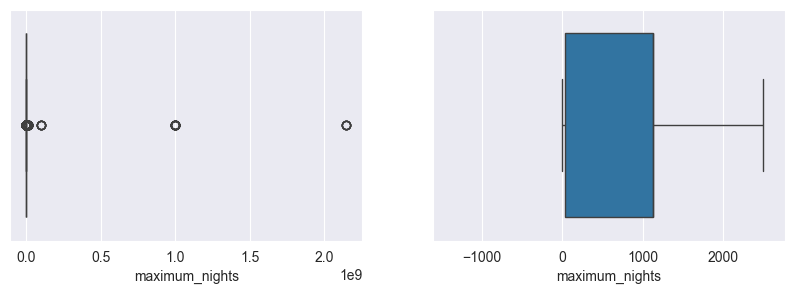

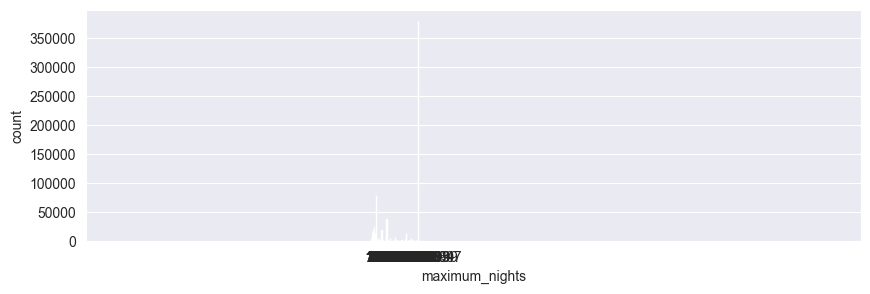

In [ ]:
print(limites(base_airbnb['maximum_nights']))
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [ ]:
# A coluna maximum_nights apresenta uma correlação muito baixa com a coluna price, esses valores são de 0,0.. e 0,00... Além disso, os valores parecem aléatórios, Por isso, essa coluna será retirada.
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)

In [ ]:
base_airbnb.shape

(710683, 21)

## Análise da coluna number_of_reviews

In [ ]:
base_airbnb['number_of_reviews'].describe()

count    668011.000000
mean          9.173174
std          23.823971
min           0.000000
25%           0.000000
50%           1.000000
75%           6.000000
max         392.000000
Name: number_of_reviews, dtype: float64

In [ ]:
base_airbnb['number_of_reviews'].value_counts()

number_of_reviews
0      268736
1       96506
2       51844
3       34733
4       24724
        ...  
364         1
309         1
322         1
359         1
349         1
Name: count, Length: 366, dtype: int64

(np.float64(-9.0), np.float64(15.0))


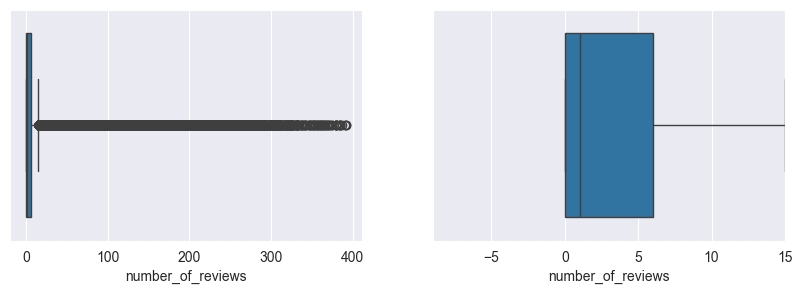

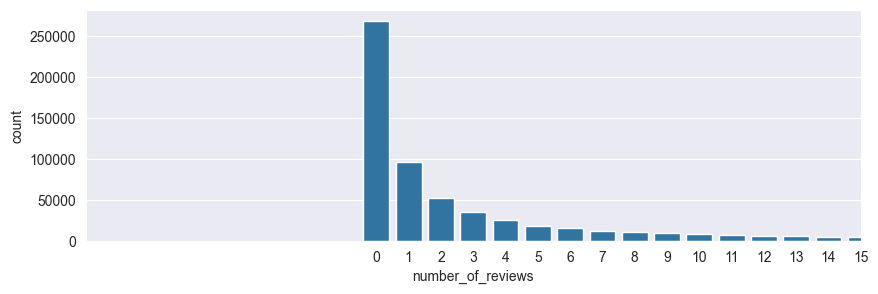

In [ ]:
print(limites(base_airbnb['number_of_reviews']))
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [ ]:
# Nesse caso, a princípio, o numero de reviews não tem correlação com a formação do preço do aluguel e sim, com a decisão do usuário de alugar o imóvel ou não. Outra avaliação e de que se o host possui um grande numero de reviews significa que o imovel dele e muito alugado e que o valor cobrado pelo aluguel está correto em relação ao que ele oferece e ao mercado. A principio, deixarei essa coluna após a criação da ML avaliarei se essa coluna continuara ou não.

In [ ]:
print(base_airbnb['property_type'].value_counts())

property_type
Apartment                 524093
House                      57211
Condominium                30636
Serviced apartment         17243
Loft                       13357
Bed and breakfast           4286
Guest suite                 4146
Hostel                      3322
Other                       2495
Guesthouse                  2460
Villa                       1392
Aparthotel                  1226
Hotel                       1139
Townhouse                   1116
Boutique hotel               531
Chalet                       517
Tiny house                   495
Earth house                  479
Casa particular (Cuba)       303
Cottage                      263
Bungalow                     227
Dorm                         195
Cabin                        141
Castle                       140
Nature lodge                 131
Treehouse                     76
Boat                          56
Island                        54
Hut                           40
Campsite                     

In [ ]:
# Todos os tipos de imoveis abaixo de 100 serão classificados como Other

tabela_tipos_imovel = base_airbnb['property_type'].value_counts()
colunas_agrupadas = []

for tipo in tabela_tipos_imovel.index:
    if tabela_tipos_imovel[tipo] <= 2500:
        colunas_agrupadas.append(tipo)
#print(colunas_agrupadas)
for tipo in colunas_agrupadas:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Other'

In [ ]:
print(base_airbnb['property_type'].value_counts())

property_type
Apartment             524093
House                  57211
Condominium            30636
Serviced apartment     17243
Other                  13717
Loft                   13357
Bed and breakfast       4286
Guest suite             4146
Hostel                  3322
Name: count, dtype: int64


## Análise da coluna room_type

room_type
Entire home/apt    368663
Private room       195214
Shared room         11602
Hotel room            966
Name: count, dtype: int64


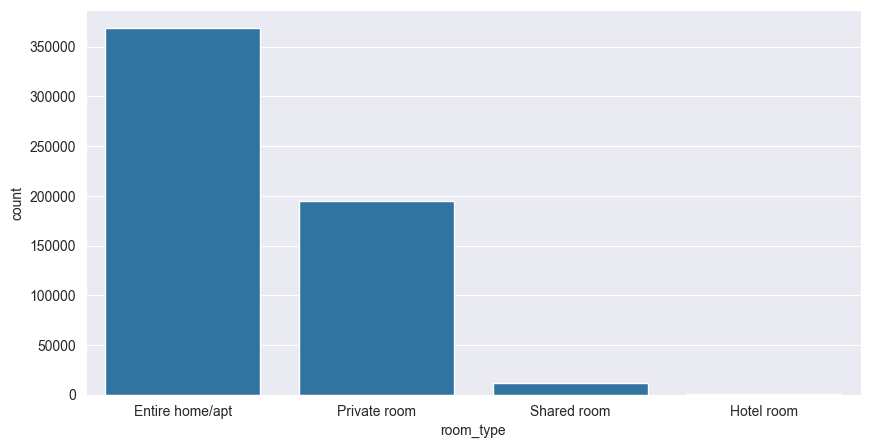

In [ ]:
print(base_airbnb['room_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='room_type', data=base_airbnb)

## Análise da coluna bed_type

bed_type
Real Bed         656242
Pull-out Sofa      8263
Futon              1770
Airbed             1189
Couch               547
Name: count, dtype: int64


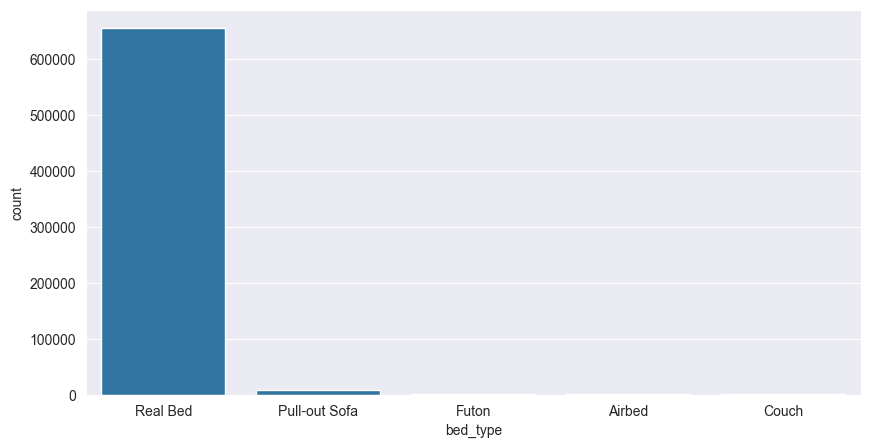

In [ ]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)

In [ ]:
# Agrupamentos de outros tipo de cama

tabela_tipos_cama = base_airbnb['bed_type'].value_counts()
colunas_agrupadas = []

for tipo in tabela_tipos_cama.index:
    if tabela_tipos_cama[tipo] <= 10000:
        colunas_agrupadas.append(tipo)
#print(colunas_agrupadas)
for tipo in colunas_agrupadas:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Other_bed'

bed_type
Real Bed     656242
Other_bed     11769
Name: count, dtype: int64


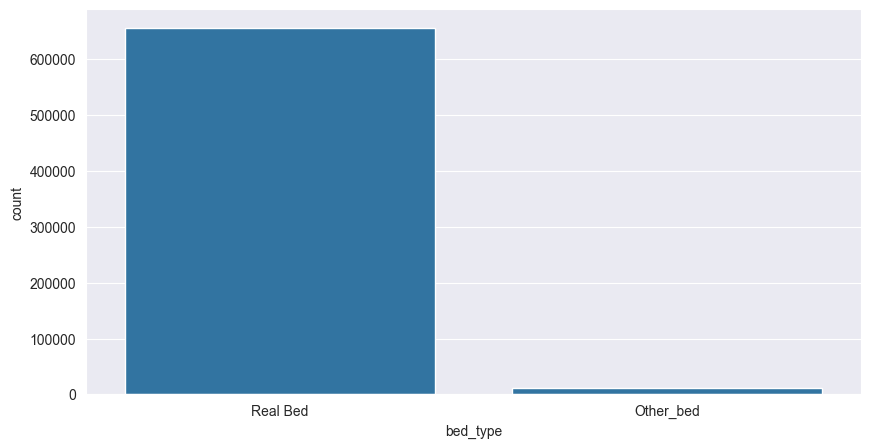

In [ ]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)

## Análise da coluna cancellation_policy

cancellation_policy
flexible                       278727
strict_14_with_grace_period    247303
moderate                       121410
strict                          12135
super_strict_60                  6020
super_strict_30                  2416
Name: count, dtype: int64


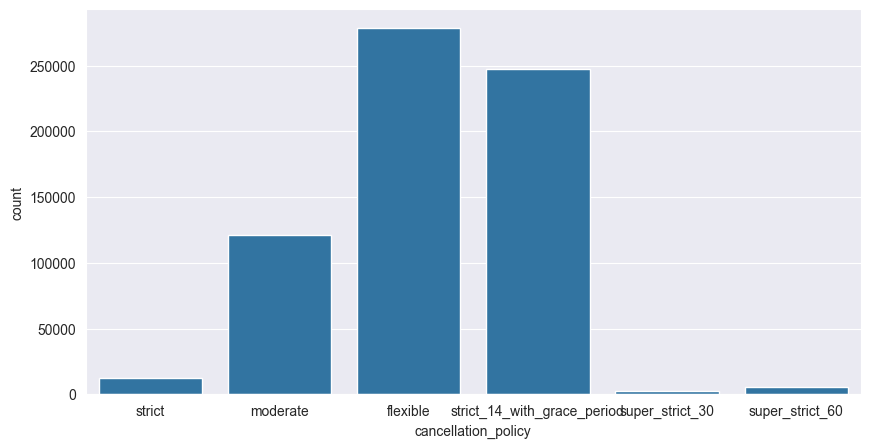

In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)

In [ ]:
# Agrupando strict, super_strict_30 e super_strict_60

tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

['strict', 'super_strict_60', 'super_strict_30']


In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())

cancellation_policy
flexible                       256417
strict_14_with_grace_period    198234
moderate                       112036
strict                           9758
Name: count, dtype: int64


## Análise da coluna amenities

In [ ]:
print(base_airbnb['amenities'].value_counts())

amenities
{}                                                                                                                                                                                6009
{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,"Buzzer/wireless intercom",Washer}                                                                        313
{"translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                                                                                        244
{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,"Buzzer/wireless intercom","Family/kid friendly",Washer}                                                  232
{"Family/kid friendly"}                                                                                                                                                            222
                                                                           

In [ ]:
# Como essa coluna apresenta uma listas de comididades de cada imovel, e não possui um padrão. Para avlaiar essa coluna, irei contar quantas comodidades o imovel possui para avaliar se vai agregar no modelo.

print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


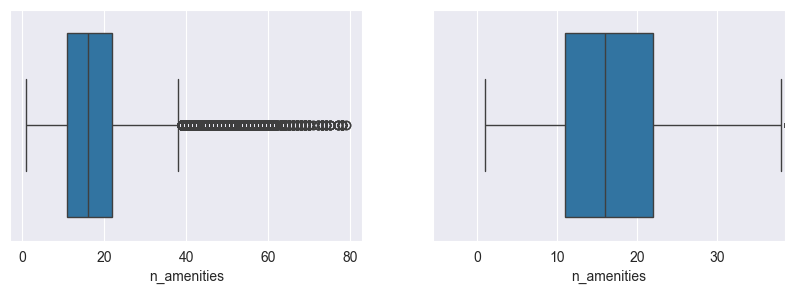

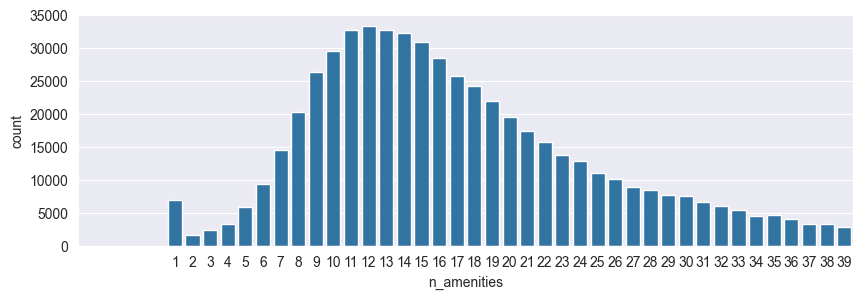

In [ ]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

## Análise da coluna latitude e longitude

In [ ]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                            center=centro_mapa, zoom=10,
                            mapbox_style='stamen-terrain')
#mapa.show()
# Salvar como HTML
mapa.write_html("mapa_densidade2.html")

# Abrir automaticamente no navegador
webbrowser.open("mapa_densidade2.html")

C:\Users\tamyc\AppData\Local\Temp\ipykernel_13728\1244898705.py:3: DeprecationWarning: *density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,


True

In [ ]:
# https://plotly.com/python/mapbox-to-maplibre/

# Amostra aleatória
amostra = base_airbnb.sample(n=50000, random_state=42)

# Centro do mapa
centro_mapa = {
    'lat': amostra['latitude'].mean(),
    'lon': amostra['longitude'].mean()
}

# Novo mapa com plotly express density_map (MapLibre)
mapa = px.density_map(
    amostra,
    lat='latitude',
    lon='longitude',
    z='price',
    radius=5,
    center=centro_mapa,
    zoom=10,
    map_style='carto-positron',  # equivalente ao stamen-terrain
    title="Mapa de Densidade de Preços do Airbnb"
)

mapa.show()


### Encoding

### Modelo de Previsão

### Análise do Melhor Modelo